# Задача проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

# Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

# Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

## Импорт библиотек

In [1]:
import os
import time
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import LocalOutlierFactor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from matplotlib import pyplot 
from matplotlib.pyplot import figure

pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.mode.chained_assignment = None 
pyplot.style.use('seaborn-deep')
STATE = 123
warnings.filterwarnings("ignore")

## Загрузка данных

In [2]:
def find(name, path):
    '''
    Function to find the data file stored locally.
    Takes name of the file and root directory.
    Scanes the local directory tree for the first orrurance of the file.
    '''
    for root, dirs, files in os.walk(path):
        if name in files:
            return os.path.join(root, name)


online_path = 'datasets/final_steel'
offline_path = '/home/'
files = [
    'data_arc.csv', 'data_bulk.csv', 'data_bulk_time.csv', 'data_gas.csv',
    'data_temp.csv', 'data_wire.csv', 'data_wire_time.csv'
]
df_list = []

for file in files:
    try:
        df = pd.read_csv(f'/{online_path}/{file}')
        df_list.append(df)
    except FileNotFoundError:
        df = pd.read_csv(find(file, offline_path))
        df_list.append(df)
        print(f"Файл {file} найден на локальном диске.")
    else:
        print(f"Файл {file} открыт в режиме online.")
print('Все файлы найдены и загружены в список датафреймов.')

Файл data_arc.csv открыт в режиме online.
Файл data_bulk.csv открыт в режиме online.
Файл data_bulk_time.csv открыт в режиме online.
Файл data_gas.csv открыт в режиме online.
Файл data_temp.csv открыт в режиме online.
Файл data_wire.csv открыт в режиме online.
Файл data_wire_time.csv открыт в режиме online.
Все файлы найдены и загружены в список датафреймов.


## Краткая сводка по датафреймам

In [3]:
counter = 0
for file in files:
    start = "\033[1m"
    end = "\033[0;0m"
    print(
        f"{counter+1} -- Внешний вид первых пяти строк датафрейма {start}{str(file).split('.')[0].upper()}{end}:"
    )
    display(df_list[counter].head())
    print()
    print(f"Размер датафрейма {start}{str(file).split('.')[0].upper()}{end}: \
        \nколичество строк - {df_list[counter].shape[0]}, \nколичество столбцов - {df_list[counter].shape[1]}."
          )
    print()
    print(
        f"Развернутая сводка датафрейма {start}{str(file).split('.')[0].upper()}{end} \nпо наименованию столбцов, типу данных, ненулевых значениях и объему памяти:"
    )
    print()
    df_list[counter].info(memory_usage='deep')
    print()
    for column in df_list[counter].columns:
        print(
            f'Количество пропусков в столбце {start}{column}{end}:    \t{df_list[counter][column].isna().sum()} шт.,  \t{round(df_list[counter][column].isna().sum()/df_list[counter].shape[0]*100, 3)}%'
        )
    print()
    for column in df_list[counter].columns:
        print(
            f'Количество уникальных значений в столбце {start}{column}{end}:    \t{df_list[counter][column].nunique()} шт.,  \t{round(df_list[counter][column].nunique()/df_list[counter].shape[0]*100, 3)}%'
        )
    print(
        '--------------------------------------------------------------------')
    print()
    print()
    counter += 1
print(f'Сводка представлена по всем {counter} датафреймам.')

1 -- Внешний вид первых пяти строк датафрейма DATA_ARC:


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.98,0.69
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.81,0.52
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.74,0.50
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.66,1.06
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.69,0.41



Размер датафрейма DATA_ARC:         
количество строк - 14876, 
количество столбцов - 5.

Развернутая сводка датафрейма DATA_ARC 
по наименованию столбцов, типу данных, ненулевых значениях и объему памяти:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 2.5 MB

Количество пропусков в столбце key:    	0 шт.,  	0.0%
Количество пропусков в столбце Начало нагрева дугой:    	0 шт.,  	0.0%
Количество пропусков в столбце Конец нагрева дугой:    	0 шт.,  	0.0%
Количество пропусков в столбце Активная мощность:    	0 шт.,  	0.0%
Ко

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.00,NaN,150.00,154.00
1,2,NaN,NaN,NaN,73.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.00,NaN,149.00,154.00
2,3,NaN,NaN,NaN,34.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.00,NaN,152.00,153.00
3,4,NaN,NaN,NaN,81.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.00,NaN,153.00,154.00
4,5,NaN,NaN,NaN,78.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.00,NaN,151.00,152.00



Размер датафрейма DATA_BULK:         
количество строк - 3129, 
количество столбцов - 16.

Развернутая сводка датафрейма DATA_BULK 
по наименованию столбцов, типу данных, ненулевых значениях и объему памяти:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56



Размер датафрейма DATA_BULK_TIME:         
количество строк - 3129, 
количество столбцов - 16.

Развернутая сводка датафрейма DATA_BULK_TIME 
по наименованию столбцов, типу данных, ненулевых значениях и объему памяти:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes:

,key,Газ 1
0,1,29.75
1,2,12.56
2,3,28.55
3,4,18.84
4,5,5.41



Размер датафрейма DATA_GAS:         
количество строк - 3239, 
количество столбцов - 2.

Развернутая сводка датафрейма DATA_GAS 
по наименованию столбцов, типу данных, ненулевых значениях и объему памяти:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB

Количество пропусков в столбце key:    	0 шт.,  	0.0%
Количество пропусков в столбце Газ 1:    	0 шт.,  	0.0%

Количество уникальных значений в столбце key:    	3239 шт.,  	100.0%
Количество уникальных значений в столбце Газ 1:    	3239 шт.,  	100.0%
--------------------------------------------------------------------


5 -- Внешний вид первых пяти строк датафрейма DATA_TEMP:


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.00
1,1,2019-05-03 11:25:53,1604.00
2,1,2019-05-03 11:29:11,1618.00
3,1,2019-05-03 11:30:01,1601.00
4,1,2019-05-03 11:30:39,1613.00



Размер датафрейма DATA_TEMP:         
количество строк - 15907, 
количество столбцов - 3.

Развернутая сводка датафрейма DATA_TEMP 
по наименованию столбцов, типу данных, ненулевых значениях и объему памяти:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.4 MB

Количество пропусков в столбце key:    	0 шт.,  	0.0%
Количество пропусков в столбце Время замера:    	0 шт.,  	0.0%
Количество пропусков в столбце Температура:    	2901 шт.,  	18.237%

Количество уникальных значений в столбце key:    	3216 шт.,  	20.218%
Количество уникальных значений в столбце Время замера:    	15907 шт.,  	100.0%
Количество уникальных значений в столбце Температура:    	175 шт.,  	1

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.24,9.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Размер датафрейма DATA_WIRE:         
количество строк - 3081, 
количество столбцов - 10.

Развернутая сводка датафрейма DATA_WIRE 
по наименованию столбцов, типу данных, ненулевых значениях и объему памяти:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB

Количество пропусков в столбце key:    	0 шт.,  	0.0%
Количество пропусков в столбце Wire 1:    	26 шт.,  	0.844%
Количество пропусков в столбце Wire 2:    	2002 шт.,  	64.979%
Количеств

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Размер датафрейма DATA_WIRE_TIME:         
количество строк - 3081, 
количество столбцов - 10.

Развернутая сводка датафрейма DATA_WIRE_TIME 
по наименованию столбцов, типу данных, ненулевых значениях и объему памяти:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 1.1 MB

Количество пропусков в столбце key:    	0 шт.,  	0.0%
Количество пропусков в столбце Wire 1:    	26 шт.,  	0.844%
Количество пропусков в столбце Wire 2:    	2002 шт.,  	64.979%
Количество про

## План работы

1. <strong>Определить тип задачи.</strong> 
- Задача представляет собой задачу регрессии. 
- Поэтому в дальнейшем будут использоваться модели для регрессии. 
2. <strong>Определить метрику для оценки качества модели.</strong>
- В качестве критерия оценки модели выберем среднюю абсолютную ошибку (Mean absolute error), как наиболее релевантную метрику, отражающую абсолютное отклонение прогноза температуры. 
3. <strong>Feature Engineering</strong>
- Большое количество пропусков в части датасетов может свидетельствовать о том, что эти данные будут иметь низкую значимость для модели. 
- Стратегия заполнения пропусков: 
    - В столбцах, содержащих 5% пропусков и менее, а также менее 60% уникальных значений, заполнить пропуски медианным значением. 
    - При 5% пропусков и менее, а также более 60% уникальных значений - средними значениями. 
    - В столбцах, содержащих более 5% пропусков, заполнить пропуски нулями. 
- Дубликаты допустимы по условиям задачи. Поэтому после объединения датасетов необходимо будет выполнить только поиск полных очевидных дубликатов. 
- Все числовые значения в различных столбцах имеют различную размерность, что потребует нормализации фичей. Что также позволит устранить влияние выбросов. 
- Все столбцы, содержащие данные о времени, необходимо перевести в формат времени, чтобы обеспечить возможность анализа данных с течением времени. 
- Все строки с пропусками замера температуры необходимо отбросить. 
- После очистки от пропусков и дубликатов проверить фичи на тип распределения. Привести все не соответствующие фичи приветсти к нормальному или близкому к нему распределению. 
- Провести анализ корреляции оставшихся фичей. 
- Провести анализ значимости фичей на примере простой линейной регрессии. 
4. <strong>Провести обучение и валидацию нескольких моделей линейной регрессии. </strong>
- Выбрать наиболее оптимальную модель для работы с отобранными фичами по метрике MAE на валидацонной выборке.  

## Предварительная подготовка данных

### Данные об электродах 

In [4]:
# выделим датафрейм данных об электродах: 
data_arc = df_list[0]

Этот датафрейм содержит отрицательное значение в столбце реактивной мощности. От этого значения необходимо избавиться. 

In [5]:
data_arc[data_arc['Реактивная мощность'] < 0]['key']

9780    2116
Name: key, dtype: int64

In [6]:
data_arc = data_arc[data_arc['key'] != 2116]

In [7]:
# согласно полученной ранее сводке столбцы, содержащие временные данные необходимо преобразовать в формат времени:
data_arc.loc[:, ('Начало нагрева дугой',
                 'Конец нагрева дугой')] = data_arc.loc[:, (
                     'Начало нагрева дугой',
                     'Конец нагрева дугой')].astype('datetime64')

In [8]:
# проверим полученный результат: 
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14872 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14872 non-null  int64         
 1   Начало нагрева дугой  14872 non-null  datetime64[ns]
 2   Конец нагрева дугой   14872 non-null  datetime64[ns]
 3   Активная мощность     14872 non-null  float64       
 4   Реактивная мощность   14872 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 697.1 KB


In [9]:
# получим время нагрева в секундах:
data_arc['time'] = ((data_arc['Конец нагрева дугой'] -
                    data_arc['Начало нагрева дугой']) / np.timedelta64(1, 's')).astype('int32')

In [10]:
# вычисление общей мощности: 
data_arc['power'] = (
    data_arc['Активная мощность']**2 +
    data_arc['Реактивная мощность']**2
)**0.5

In [11]:
# вычисление работы: 
data_arc['work'] = data_arc['power'] * data_arc['time']

In [12]:
# отбросим столбцы:
data_arc = data_arc.drop('Реактивная мощность', axis=1)

In [13]:
# переименуем столбцы:
data_arc = data_arc.rename(columns={
    'Активная мощность': 'active_power'
   })

In [14]:
# посчитаем количество циклов нагрева для каждой партии: 
heating_count = data_arc['key'].value_counts()

In [15]:
# получим сумму каждого столбца для каждой партии: 
data_arc = data_arc.groupby('key').sum()

In [16]:
# добавим данные о количестве нагревов
data_arc['arc_heating_count'] = heating_count

In [17]:
data_arc = data_arc.reset_index(level=0)

In [18]:
# финальный вид датафрейма данных об электродах: 
data_arc.head()

,key,active_power,time,power,work,arc_heating_count
0,1,4.88,1098,5.83,1442.38,5
1,2,3.05,811,3.65,881.23,4
2,3,2.53,655,2.99,525.07,5
3,4,3.21,741,3.81,796.91,4
4,5,3.35,869,4.04,1199.14,4


In [19]:
# напишем функцию построения графиков для визуализации выбросов:
def scatter_box(df,
                columns,
                size=(12, 7),
                alpha=0.3,
                title=None,
                xlabel=None,
                ylabel=None):
    fig, ax = pyplot.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]})
    fig.set_size_inches(size)
    ax[0].set_title(title, fontsize=16)
    ax[0].set_xlabel(xlabel, fontsize=14)
    ax[0].set_ylabel(ylabel, fontsize=14)
    for column in columns:
        ax[0].scatter(x=df.index, y=df[column], label=column, alpha=alpha)
    if len(columns) > 1:
        ax[0].legend()
    ax[0].grid(True)
    ax[1].boxplot(df[columns], labels=[*columns])
    pyplot.tight_layout()

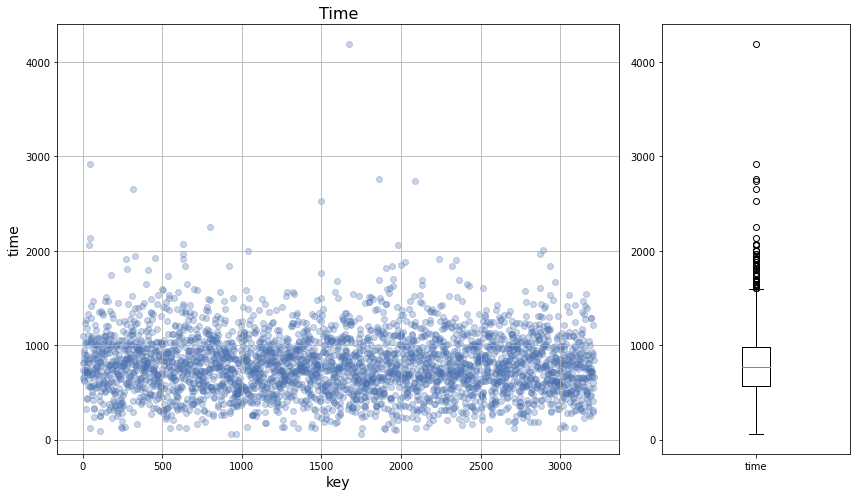

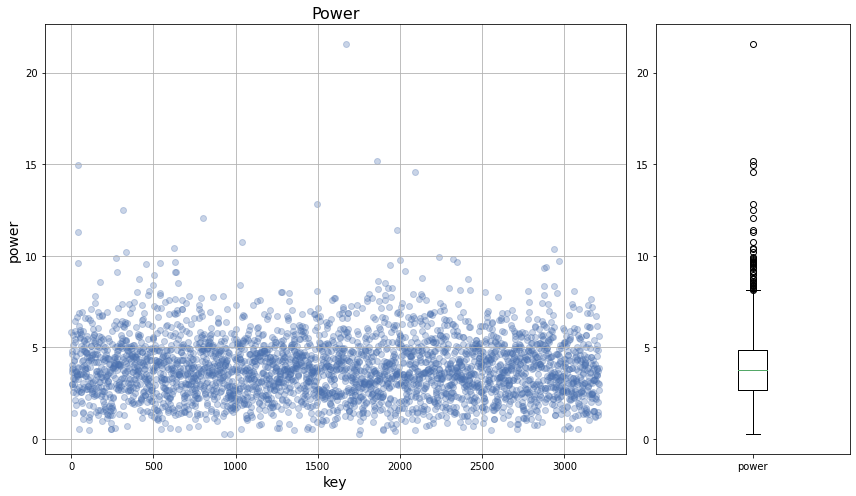

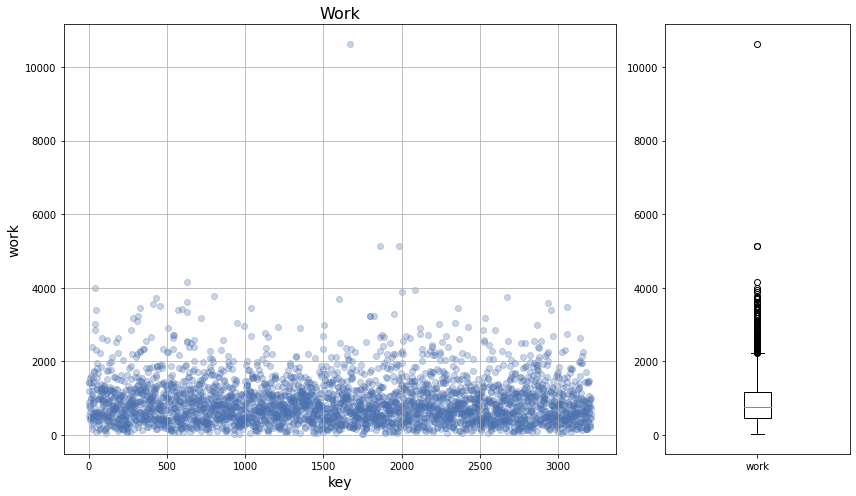

In [20]:
# получим визуализацию мощности, работы и времени нагрева:
columns = ['time', 'power', 'work']
for column in columns: 
    scatter_box(data_arc, [column],
            size=(12, 7),
            alpha=0.3,
            title=column.title(),
            xlabel='key',
            ylabel=column)

### Данные о сыпучих и проволочных материалах 

In [21]:
# выделим соответствующие датафреймы: 
data_bulk = df_list[1]
data_wire = df_list[5]

In [22]:
# в каждый датафрейм добавим столбец с счетчиком внесения добавок/проволоки: 
data_bulk['bulk_counter'] = data_bulk.count(axis=1)
data_wire['wire_counter'] = data_wire.count(axis=1)

In [23]:
# заполним отсутствующие значения нулем, т.к. для соответствующих партий материалы не использовались: 
data_bulk.fillna(0, inplace=True)
data_wire.fillna(0, inplace=True)

In [24]:
# отбросим столбцы, сумма значений которых равна 0, если таковые есть: 
data_bulk = data_bulk.loc[:, (data_bulk.sum(axis=0) != 0)]
data_wire = data_wire.loc[:, (data_wire.sum(axis=0) != 0)]

In [25]:
# в каждый датафрейм добавим столбец со средним значением внесения добавок/проволоки: 
data_bulk['bulk_avg'] = data_bulk.mean(axis=1)
data_wire['wire_avg'] = data_wire.mean(axis=1)
#data_bulk['bulk_sum'] = data_bulk.sum(axis=1)
#data_wire['wire_sum'] = data_wire.sum(axis=1)

In [26]:
# проверим полученный результат: 
display(data_bulk.head())
display(data_wire.head())

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,bulk_counter,bulk_avg
0,1,0.00,0.00,0.00,43.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,206.00,0.00,150.00,154.00,5,32.88
1,2,0.00,0.00,0.00,73.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,206.00,0.00,149.00,154.00,5,34.65
2,3,0.00,0.00,0.00,34.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,205.00,0.00,152.00,153.00,5,32.47
3,4,0.00,0.00,0.00,81.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,207.00,0.00,153.00,154.00,5,35.53
4,5,0.00,0.00,0.00,78.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,203.00,0.00,151.00,152.00,5,34.94


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,wire_counter,wire_avg
0,1,60.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2,5.73
1,2,96.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2,9.10
2,3,91.16,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2,8.74
3,4,89.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2,8.64
4,5,89.24,9.11,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3,9.67


### Данные о продувке сплава газом

In [27]:
# выделим соответствующий датафрейм: 
data_gas = df_list[3]

In [28]:
# переименуем столбец: 
data_gas = data_gas.rename(columns={
    'Газ 1': 'gas',
})

In [29]:
# финальный вид датафрейма
data_gas.head()

,key,gas
0,1,29.75
1,2,12.56
2,3,28.55
3,4,18.84
4,5,5.41


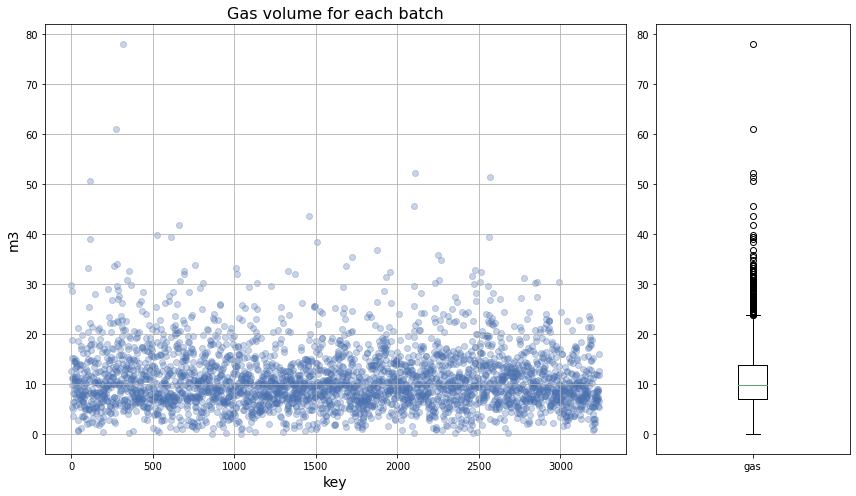

In [30]:
scatter_box(data_gas, ['gas'],
            size=(12, 7),
            alpha=0.3,
            title='Gas volume for each batch',
            xlabel='key',
            ylabel='m3')

### Данные о замерах температуры

In [31]:
# выделим соответствующий датафрейм: 
data_temp = df_list[4]

In [32]:
# приведем столбец, содержащий время замера к соответствующему типу: 
data_temp['Время замера'] = data_temp['Время замера'].astype('datetime64')

In [33]:
# удалим пропуски: 
data_temp = data_temp.dropna()

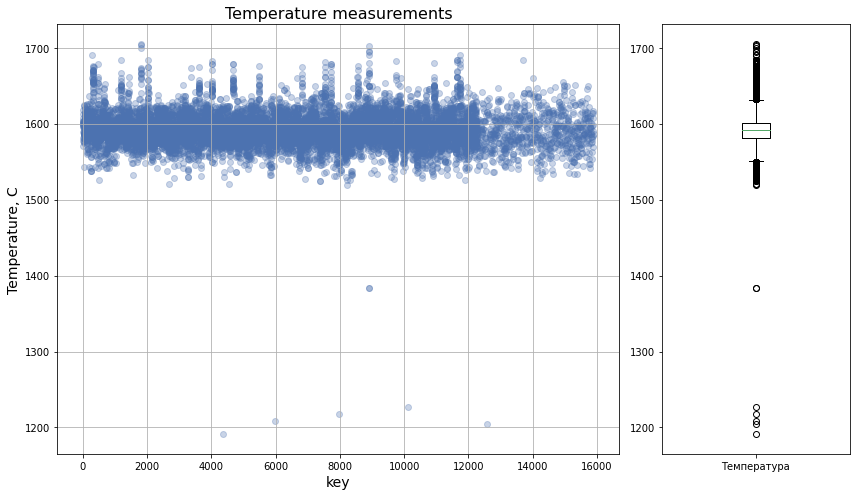

In [34]:
# рассмотрим полученные данные: 
scatter_box(data_temp, ['Температура'],
            size=(12, 7),
            alpha=0.3,
            title='Temperature measurements',
            xlabel='key',
            ylabel='Temperature, C')

Помимо выбросов ниже минимальных значений обращает на себя внимание "хвост" первого графика - слишком разреженные данные. Рассмотрим последние 40 строк датафрейма. 

In [35]:
data_temp.tail(40)

,key,Время замера,Температура
15723,3201,2019-08-30 21:45:35,1650.00
15730,3202,2019-08-30 22:47:33,1588.00
15735,3203,2019-08-30 23:33:29,1571.00
15741,3204,2019-08-31 00:12:27,1574.00
15745,3205,2019-08-31 00:44:47,1593.00
15751,3206,2019-08-31 01:20:04,1603.00
15754,3208,2019-08-31 01:50:26,1547.00
15758,3209,2019-08-31 02:20:46,1562.00
15761,3210,2019-08-31 03:54:18,1622.00
15766,3211,2019-08-31 04:32:37,1587.00


Как минимум несколько десятков замеров - одиночные. Т.е. для этих партий невозможно определить, что в датафрейме - исходная или искомая температура. Поэтому от этих данных придется избавиться. 

In [36]:
# посчитаем количество замеров для каждой партии: 
measurement_count = data_temp['key'].value_counts()

In [37]:
# выделим те партии, что имеют только один замер: 
one_measure = measurement_count[measurement_count == 1].index

In [38]:
# удалим все партии, что имеют только один замер температуры: 
data_temp = data_temp[~data_temp.key.isin(one_measure)]

Найдем начальную и конечную температуры для каждой партии:

In [39]:
data_temp_first = pd.merge(data_temp.groupby('key')['Время замера'].agg('min'),
                           data_temp,
                           how='left',
                           on='Время замера')
data_temp_last = pd.merge(data_temp.groupby('key')['Время замера'].agg('max'),
                          data_temp,
                          how='left',
                          on='Время замера')

In [40]:
# объединим таблицы: 
df = pd.merge(data_temp_first[['key', 'Температура']],
              data_temp_last[['key', 'Температура']],
              how="outer",
              on="key")
df.head()

,key,Температура_x,Температура_y
0,1,1571.00,1613.00
1,2,1581.00,1602.00
2,3,1596.00,1599.00
3,4,1601.00,1625.00
4,5,1576.00,1602.00


In [41]:
# переименуем столбцы:
df = df.rename(columns={
    'Температура_x': 'initial_temperature',
    'Температура_y': 'final_temperature'
})

In [42]:
# добавим разницу во времени первого и последнего замеров: 
df = pd.merge(df,
              data_temp[['key', 'Время замера']].groupby('key')['Время замера'].agg(
                  lambda x: x.max() - x.min()).dt.total_seconds(),
              how='left',
              on='key').astype('int64')
df = df.rename(columns={'Время замера': 'measurement_time'})

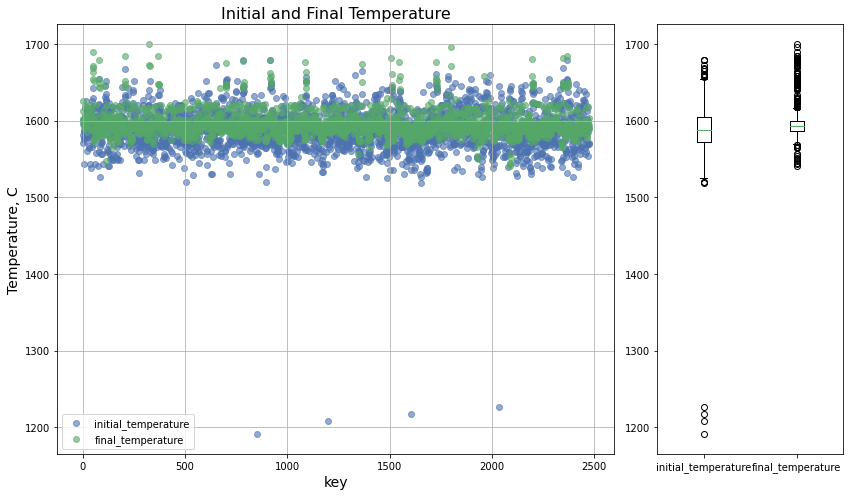

In [43]:
# рассмотрим полученный датафрейм: 
scatter_box(df, ['initial_temperature', 'final_temperature'],
            size=(12, 7),
            alpha=0.6,
            title='Initial and Final Temperature',
            xlabel='key',
            ylabel='Temperature, C')

### Объединение таблиц

In [44]:
df = pd.merge(df, data_gas, how="left", on=["key"])
df = pd.merge(df, data_wire, how="left", on=["key"])
df = pd.merge(df, data_bulk, how="left", on=["key"])
df = pd.merge(df, data_arc, how="left", on=["key"]) 
df = df.set_index('key')
df.head(5)

,initial_temperature,final_temperature,measurement_time,gas,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,...,Bulk 13,Bulk 14,Bulk 15,bulk_counter,bulk_avg,active_power,time,power,work,arc_heating_count
key,,,,,,,,,,,,,,,,,,,,,
1,1571,1613,861,29.75,60.06,0.00,0.00,0.00,0.00,0.00,...,0.00,150.00,154.00,5.00,32.88,4.88,1098.00,5.83,1442.38,5.00
2,1581,1602,1305,12.56,96.05,0.00,0.00,0.00,0.00,0.00,...,0.00,149.00,154.00,5.00,34.65,3.05,811.00,3.65,881.23,4.00
3,1596,1599,1300,28.55,91.16,0.00,0.00,0.00,0.00,0.00,...,0.00,152.00,153.00,5.00,32.47,2.53,655.00,2.99,525.07,5.00
4,1601,1625,388,18.84,89.06,0.00,0.00,0.00,0.00,0.00,...,0.00,153.00,154.00,5.00,35.53,3.21,741.00,3.81,796.91,4.00
5,1576,1602,762,5.41,89.24,9.11,0.00,0.00,0.00,0.00,...,0.00,151.00,152.00,5.00,34.94,3.35,869.00,4.04,1199.14,4.00


## Анализ полученных фичей

In [45]:
# получим общую сводку: 
df.describe()

,initial_temperature,final_temperature,measurement_time,gas,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,...,Bulk 13,Bulk 14,Bulk 15,bulk_counter,bulk_avg,active_power,time,power,work,arc_heating_count
count,2475.00,2475.00,2475.00,2473.00,2372.00,2372.00,2372.00,2372.00,2372.00,2372.00,...,2407.00,2407.00,2407.00,2407.00,2407.00,2474.00,2474.00,2474.00,2474.00,2474.00
mean,1588.40,1595.34,1854.95,11.14,102.26,17.86,3.18,0.30,0.00,0.96,...,1.03,153.82,116.95,4.55,109.40,3.13,800.10,3.91,904.35,4.63
std,29.24,16.02,1301.24,6.32,43.64,33.94,27.69,4.71,0.00,8.62,...,14.00,81.90,85.58,1.24,45.01,1.43,340.77,1.78,655.39,1.61
min,1191.00,1541.00,234.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,2.00,5.59,0.19,57.00,0.26,15.16,1.00
25%,1572.00,1587.00,1182.50,7.11,72.86,0.00,0.00,0.00,0.00,0.00,...,0.00,105.00,0.00,4.00,73.38,2.15,573.00,2.69,461.41,4.00
50%,1588.00,1593.00,1593.00,9.93,101.09,0.00,0.00,0.00,0.00,0.00,...,0.00,149.00,106.00,5.00,108.18,3.02,772.50,3.76,768.32,4.00
75%,1605.00,1599.00,2262.50,13.87,128.14,23.16,0.00,0.00,0.00,0.00,...,0.00,204.00,204.00,5.00,146.09,3.91,986.75,4.87,1168.81,6.00
max,1679.00,1700.00,23537.00,78.00,330.31,282.78,385.01,113.23,0.00,180.45,...,305.00,636.00,405.00,8.00,212.88,17.50,4189.00,21.56,10630.98,16.00


In [46]:
# проверим наличие пропусков: 
df.isna().sum()

initial_temperature      0
final_temperature        0
measurement_time         0
gas                      2
Wire 1                 103
Wire 2                 103
Wire 3                 103
Wire 4                 103
Wire 5                 103
Wire 6                 103
Wire 7                 103
Wire 8                 103
Wire 9                 103
wire_counter           103
wire_avg               103
Bulk 1                  68
Bulk 2                  68
Bulk 3                  68
Bulk 4                  68
Bulk 5                  68
Bulk 6                  68
Bulk 7                  68
Bulk 8                  68
Bulk 9                  68
Bulk 10                 68
Bulk 11                 68
Bulk 12                 68
Bulk 13                 68
Bulk 14                 68
Bulk 15                 68
bulk_counter            68
bulk_avg                68
active_power             1
time                     1
power                    1
work                     1
arc_heating_count        1
d

In [47]:
# определим номера партий, для которых отсутствуют данные: 
inds = pd.isnull(df).any(1)
inds = (inds[inds] == True).index
print(sorted(inds))

[51, 52, 53, 54, 55, 56, 72, 80, 81, 82, 83, 84, 85, 88, 109, 110, 151, 188, 193, 197, 209, 210, 211, 212, 225, 259, 269, 302, 330, 331, 332, 343, 350, 375, 376, 377, 378, 661, 711, 712, 713, 714, 715, 744, 748, 754, 755, 796, 797, 798, 799, 800, 830, 841, 874, 929, 930, 931, 932, 933, 934, 960, 961, 964, 966, 983, 984, 1062, 1102, 1103, 1104, 1105, 1106, 1107, 1184, 1221, 1268, 1334, 1379, 1380, 1402, 1517, 1518, 1525, 1526, 1527, 1528, 1535, 1564, 1565, 1566, 1623, 1646, 1656, 1743, 1744, 1745, 1746, 1747, 1748, 1758, 1783, 1817, 1818, 1836, 1911, 1946, 1959, 1974, 1977, 1978, 1979, 2009, 2010, 2043, 2056, 2116, 2195, 2196, 2197, 2198, 2214, 2215, 2216, 2217, 2218, 2219, 2231, 2236, 2238, 2310, 2360, 2367, 2368, 2369, 2370, 2388, 2389, 2390, 2391, 2392, 2393, 2408, 2434, 2460, 2468, 2471]


In [48]:
# отбросим все данные с пропусками: 
df = df.dropna()

In [49]:
# т.к. время замера температуры никак не влияет на физику процесса, удалим этот столбец
df = df.drop('measurement_time', axis=1)

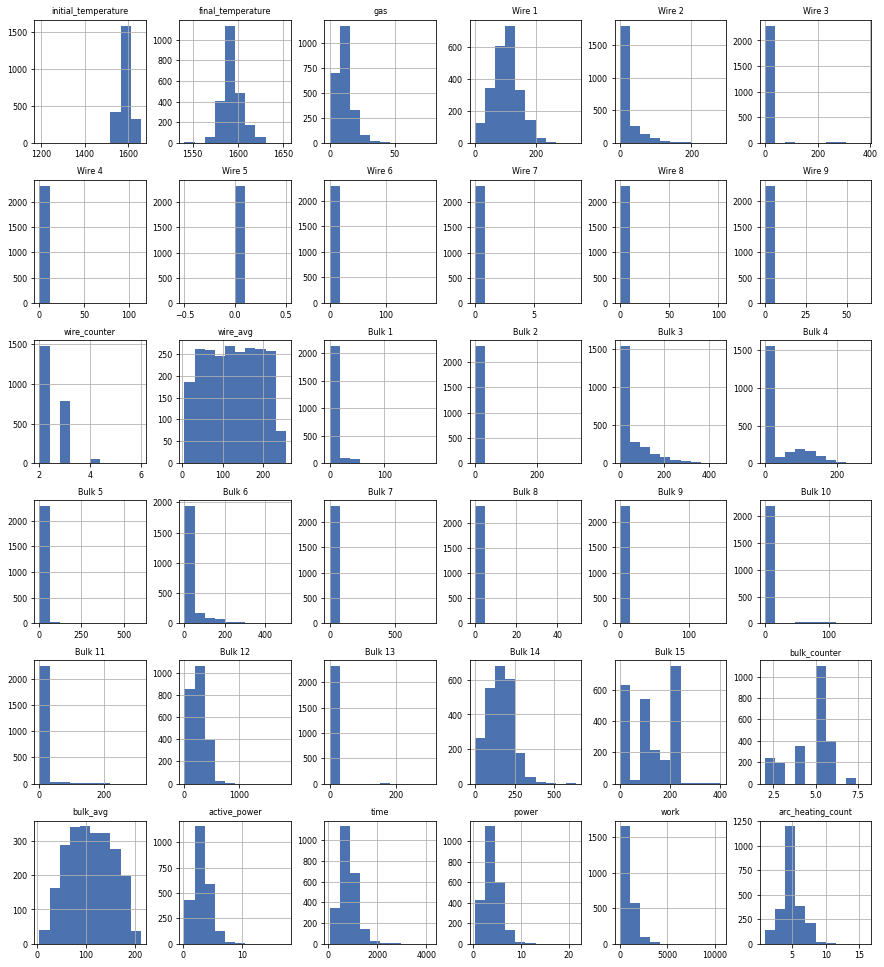

In [50]:
# рассмотрим типы распределений по каждой фиче: 
fig = df.hist(xlabelsize=8, ylabelsize=8, figsize=(15, 17))
[x.title.set_size(8) for x in fig.ravel()];

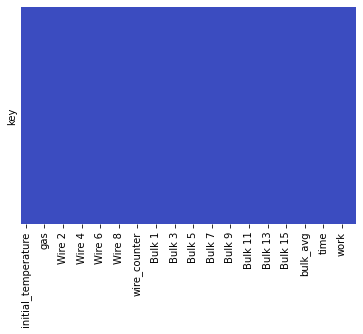

In [51]:
# рассмотрим тепловую карту пропусков в датасете: 
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='coolwarm');

In [52]:
# форма полученного датафрейма: 
df.shape

(2328, 36)

### Промежуточные выводы

- Обнаружено большое количество пропусков на финальном датасете. Эти данные необходимо перепроверить с заказчиком. Необходимо понять причину их появления. 
- Имеется некое количество выбросов практически по каждому параметру.   
- Фичи имеют самый разный масштаб, что может отрицательно сказаться на обучении некоторых моделей. 
- Распределение большинства фичей далеко от нормального. 
- Большое количество пропусков, заполненных нулями, для сыпучих материалов приводит к смещению большинства соответствующих графиков влево. Можно предположить, что значимость этих фичей для моделей будет невысокой. 
- Диапазон начальных и финальных температур примерно одинаковы. 

## Разделение данных

In [53]:
target = df['final_temperature']
features = df.drop('final_temperature', axis=1)

In [54]:
# выделим данные для обучения и тестирования:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.33, random_state=STATE)

### Очистка от выбросов

In [55]:
# определим столбцы, которые необходимо очистить от выбросов:
columns = [
    'time', 'power', 'work', 'gas'
]

In [56]:
# создадим функцию идентификации выбросов по IQR:
def outliers(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1

    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    ls = df.index[(df[column] < lower) | (df[column] > upper)]
    return ls

In [57]:
# создадим список удаляемых индексов и выведем его длину (индексы могут повторяться): 
index_list = []
for column in columns: 
    index_list.extend(outliers(df, column))
print(len(index_list))

270


In [58]:
# зададим функцию очистки датафрейма от выбросов: 
def remove_outliers(df, ls): 
    ls = sorted(set(ls))
    df = df.drop(ls)
    return df

In [59]:
df_cleaned = remove_outliers(df, index_list)

In [60]:
print(f'Размер датафрейма с выбросами: {df.shape}')
print(f'Размер датафрейма без выбросов: {df_cleaned.shape}')

Размер датафрейма с выбросами: (2328, 36)
Размер датафрейма без выбросов: (2148, 36)


In [61]:
# разделим данные для обучения модели: 
cleaned_target = df_cleaned['final_temperature']
cleaned_features = df_cleaned.drop(['final_temperature'], axis=1)

In [62]:
cleaned_features_train, cleaned_features_test, cleaned_target_train, cleaned_target_test = train_test_split(
    cleaned_features, cleaned_target, test_size=0.33, random_state=STATE)

### Масштабирование датафрейма

In [63]:
scaler = StandardScaler()

In [64]:
scaler.fit(cleaned_features_train)

StandardScaler()

In [65]:
norm_features_train = scaler.transform(cleaned_features_train)
norm_features_test = scaler.transform(cleaned_features_test)

In [66]:
norm_features_train = pd.DataFrame(norm_features_train,
                                   columns=features_train.columns)
norm_features_test = pd.DataFrame(norm_features_test,
                                  columns=features_test.columns)

## Модель - LinearRegression

### На нормализованных данных

In [67]:
%%time
model = LinearRegression()
norm_lr = -(cross_val_score(model, 
                             norm_features_train, 
                             cleaned_target_train, 
                             cv=5, 
                             scoring='neg_mean_absolute_error').mean())
print(f'Среднее значение MAE на кросс-валидации модели {model}: ', round(norm_lr, 3))


Среднее значение MAE на кросс-валидации модели LinearRegression():  6.241
CPU times: user 363 ms, sys: 759 ms, total: 1.12 s
Wall time: 1.12 s


## Модель - DecisionTreeRegressor

### На данных без выбросов

In [68]:
%%time

model = DecisionTreeRegressor() 
param_grid = {
    'criterion':
    ['friedman_mse'],
    'max_depth': [x for x in range(7, 9)],
    'random_state': [STATE],
    'min_samples_leaf': range(48, 50),
    'min_samples_split': range(2, 6),
}
grid = GridSearchCV(model, param_grid, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
grid.fit(cleaned_features_train, cleaned_target_train)
best_model = grid.best_params_
print("Метрики на обучающей выборке:")
print()
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1), params))
print()
print('Лучшие параметры на обучающей выборке:')
print(best_model)
clean_dt = (max(means)*-1)
print()
print(f'Лучшая метрика модели {model}: {clean_dt}')
print()

Метрики на обучающей выборке:

6.885385 for {'criterion': 'friedman_mse', 'max_depth': 7, 'min_samples_leaf': 48, 'min_samples_split': 2, 'random_state': 123}
6.885385 for {'criterion': 'friedman_mse', 'max_depth': 7, 'min_samples_leaf': 48, 'min_samples_split': 3, 'random_state': 123}
6.885385 for {'criterion': 'friedman_mse', 'max_depth': 7, 'min_samples_leaf': 48, 'min_samples_split': 4, 'random_state': 123}
6.885385 for {'criterion': 'friedman_mse', 'max_depth': 7, 'min_samples_leaf': 48, 'min_samples_split': 5, 'random_state': 123}
6.882675 for {'criterion': 'friedman_mse', 'max_depth': 7, 'min_samples_leaf': 49, 'min_samples_split': 2, 'random_state': 123}
6.882675 for {'criterion': 'friedman_mse', 'max_depth': 7, 'min_samples_leaf': 49, 'min_samples_split': 3, 'random_state': 123}
6.882675 for {'criterion': 'friedman_mse', 'max_depth': 7, 'min_samples_leaf': 49, 'min_samples_split': 4, 'random_state': 123}
6.882675 for {'criterion': 'friedman_mse', 'max_depth': 7, 'min_samples_l

## Модель - RandomForestRegressor

### На данных без выбросов

In [69]:
%%time

model = RandomForestRegressor() 
param_grid = {
    'criterion': ['mse'],
    'max_depth': [9, 10],
    'random_state': [STATE],
    'min_samples_leaf': [65],
    'min_samples_split': [3],
    'n_estimators':[744],
}
grid = RandomizedSearchCV(model, param_grid, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
grid.fit(cleaned_features_train, cleaned_target_train)
best_model = grid.best_params_
print("Метрики на обучающей выборке:")
print()
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1), params))
print()
print()
print('Лучшие параметры на обучающей выборке:')
print(best_model)
clean_rf = (max(means) * -1)
print()
print(f'Лучшая метрика модели {model}: {clean_rf}')
print()

Метрики на обучающей выборке:

6.576618 for {'random_state': 123, 'n_estimators': 744, 'min_samples_split': 3, 'min_samples_leaf': 65, 'max_depth': 9, 'criterion': 'mse'}
6.576618 for {'random_state': 123, 'n_estimators': 744, 'min_samples_split': 3, 'min_samples_leaf': 65, 'max_depth': 10, 'criterion': 'mse'}


Лучшие параметры на обучающей выборке:
{'random_state': 123, 'n_estimators': 744, 'min_samples_split': 3, 'min_samples_leaf': 65, 'max_depth': 9, 'criterion': 'mse'}

Лучшая метрика модели RandomForestRegressor(): 6.576618373335004

CPU times: user 37.6 s, sys: 181 ms, total: 37.8 s
Wall time: 41.1 s


## Модель - LGBMRegressor

### На данных без выбросов

In [70]:
%%time

model = LGBMRegressor() 
param_grid = {
    'num_leaves':[22], 
    'learning_rate':[0.05],
    'random_state': [STATE]
}
grid = GridSearchCV(model, param_grid, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
grid.fit(cleaned_features_train, cleaned_target_train)
best_model = grid.best_params_
print("Метрики на обучающей выборке:")
print()
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1), params))
print()
print('Лучшие параметры на обучающей выборке:')
print(best_model)
clean_lgbm = (max(means) * -1)
print()
print(f'Лучшая метрика модели {model}: {clean_lgbm}')
print()

Метрики на обучающей выборке:

5.940120 for {'learning_rate': 0.05, 'num_leaves': 22, 'random_state': 123}

Лучшие параметры на обучающей выборке:
{'learning_rate': 0.05, 'num_leaves': 22, 'random_state': 123}

Лучшая метрика модели LGBMRegressor(): 5.940119974582286

CPU times: user 30min 2s, sys: 14.4 s, total: 30min 17s
Wall time: 30min 28s


## Модель - XGBRegressor

### На данных без выбросов

In [71]:
%%time

model = XGBRegressor() 
param_grid = {
    'learning_rate': [0.08],
    'max_depth': [10],
    'min_child_weight': [8],
    'gamma': [0.2],
    'colsample_bytree': [0.9],
    'random_state': [STATE]
}

grid = GridSearchCV(model, param_grid, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
grid.fit(cleaned_features_train, cleaned_target_train)
best_model = grid.best_params_
print('Метрики на обучающей выборке:')
print()
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1), params))
print()
print('Лучшие параметры на обучающей выборке:')
print(best_model)
clean_xgbr = (max(means) * -1)
print()
print(f'Лучшая метрика модели {model}: {clean_xgbr}')
print()

Метрики на обучающей выборке:

5.904333 for {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.08, 'max_depth': 10, 'min_child_weight': 8, 'random_state': 123}

Лучшие параметры на обучающей выборке:
{'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.08, 'max_depth': 10, 'min_child_weight': 8, 'random_state': 123}

Лучшая метрика модели XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_pa

## Анализ моделей

In [72]:
rating = {
    'LinearRegression on normalized data': norm_lr,
    'DecisionTreeRegressor on cleaned data': clean_dt, 
    'RandomForestRegressor on cleaned data': clean_rf, 
    'LGBMRegressor on cleaned data': clean_lgbm,
    'XGBRegressor on cleaned data': clean_xgbr,
    
}

In [73]:
analysis_df = pd.DataFrame(rating, index=['MAE']).T

In [74]:
analysis_df.sort_values(by='MAE', axis=0, ascending=True, inplace=True)

In [75]:
analysis_df

,MAE
XGBRegressor on cleaned data,5.90
LGBMRegressor on cleaned data,5.94
LinearRegression on normalized data,6.24
RandomForestRegressor on cleaned data,6.58
DecisionTreeRegressor on cleaned data,6.88


### Значимость фичей лучшей модели

In [76]:
best_model = XGBRegressor(colsample_bytree=0.9, gamma=0.2, learning_rate=0.08, max_depth=10, min_child_weight=8,random_state=STATE)

In [77]:
best_model.fit(cleaned_features_train, cleaned_target_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, enable_categorical=False,
             gamma=0.2, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.08, max_delta_step=0,
             max_depth=10, min_child_weight=8, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [78]:
feature_importance_df = pd.DataFrame(best_model.feature_importances_,
                                     index=features.columns).sort_values(
                                         0, ascending=False)
print(feature_importance_df)

                       0
Wire 6              0.09
initial_temperature 0.07
Bulk 6              0.07
Bulk 1              0.07
Wire 2              0.06
work                0.06
active_power        0.05
Bulk 11             0.05
Wire 3              0.04
Bulk 15             0.04
Wire 1              0.04
Bulk 5              0.04
power               0.04
Bulk 12             0.03
wire_counter        0.03
wire_avg            0.03
time                0.03
Bulk 4              0.03
gas                 0.02
bulk_avg            0.02
Bulk 14             0.02
Bulk 10             0.02
arc_heating_count   0.02
Bulk 3              0.02
bulk_counter        0.01
Bulk 9              0.00
Bulk 8              0.00
Bulk 13             0.00
Bulk 7              0.00
Wire 7              0.00
Wire 9              0.00
Wire 5              0.00
Bulk 2              0.00
Wire 4              0.00
Wire 8              0.00


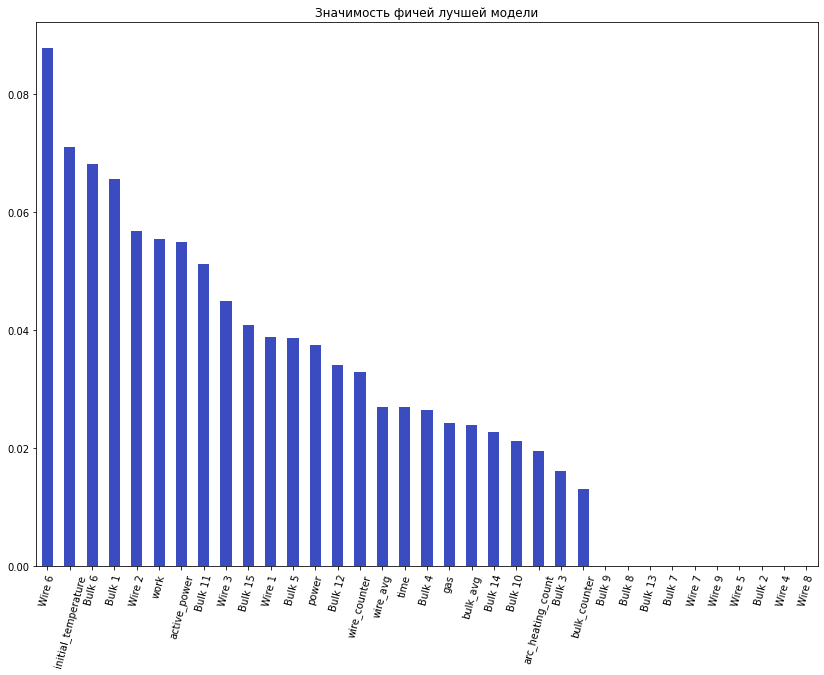

In [79]:
feature_importance_df.plot(kind='bar',
                           figsize=(14, 10),
                           title="Значимость фичей лучшей модели",
                           legend=False,
                           rot=75,
                           fontsize=10,
                           colormap='coolwarm');

## Тестирование лучшей модели

In [80]:
prediction = best_model.predict(cleaned_features_test)

In [81]:
best_model_test_mae = mean_absolute_error(prediction, cleaned_target_test)
print(f'MAE на тестовых данных лучшей модели {best_model}', best_model_test_mae)

MAE на тестовых данных лучшей модели XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, enable_categorical=False,
             gamma=0.2, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.08, max_delta_step=0,
             max_depth=10, min_child_weight=8, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None) 5.770530539271862


## Вывод

В процессе работы с данными были выявлены проблемы в виде пропусков значений, отсутствия части замеров температуры для последних партий, предложены несколько расчетных фичей, которые положительно сказались на обучении моделей, определены наиболее существенные параметры и наиболее продуктивные модели. 

Наилучший результат показывают модели на датасете, очищенном от выбросов. Нормализация параметров также привела к уменьшению ошибки в предсказаниях. 

Первоначальный план работы с данными не мог быть выполнен в части заполнения пропусков, т.к. специфика данных - технологический процесс - подразумевает либо добавление, либо недобавление тех или иных ингридиентов. Поэтому заполнение пропусков средними или медианными значениями не имеет смысла. Вместо этого пропуски были заполнены нулевыми значениями. 

Также обработка данных о времени не имела смысла за исключением датафрейма, содержащего данные об электродах.   

Были использованы следующие признаки: 

- <strong>initial_temperature</strong> - начальная температура сплава
- <strong>work</strong> - работа, затраченная на каждую партию
- <strong>active_power</strong> - сумма активной мощности для каждой партии
- <strong>power</strong> - общая мощность для каждой партии (корень квадратный суммы квадратов активной и реактивной мощностей)
- <strong>time</strong> - суммарное время нагрева для каждой партии
- <strong>arc_heating_count</strong> - количество нагревов электродов для каждой партии
- <strong>gas</strong> - объем газа для продувки каждой партии
- <strong>Bulk 1</strong> - объем подачи сыпучего материала из бункера 1
- <strong>Bulk 3</strong> - объем подачи сыпучего материала из бункера 3
- <strong>Bulk 4</strong> - объем подачи сыпучего материала из бункера 4 
- <strong>Bulk 5</strong> -  объем подачи сыпучего материала из бункера 5
- <strong>Bulk 6</strong> - объем подачи сыпучего материала из бункера 6
- <strong>Bulk 10</strong> - объем подачи сыпучего материала из бункера 10
- <strong>Bulk 11</strong> - объем подачи сыпучего материала из бункера 11
- <strong>Bulk 12</strong> - объем подачи сыпучего материала из бункера 12
- <strong>Bulk 14 </strong> - объем подачи сыпучего материала из бункера 14
- <strong>Bulk 15</strong> - объем подачи сыпучего материала из бункера 15
- <strong>bulk_counter </strong> - количество раз загрузки сыпучих материалов для каждой партии
- <strong>bulk_avg</strong> - средний объем загрузки сыпучих материалов для каждой партии
- <strong>Wire 1</strong> - объем подачи проволоки из трайб-аппарата 1
- <strong>Wire 2 </strong> - объем подачи проволоки из трайб-аппарата 2
- <strong>Wire 3</strong> - объем подачи проволоки из трайб-аппарата 3
- <strong>wire_counter</strong> - количество раз загрузки проволочных материалов для каждой партии
- <strong>wire_avg</strong> - средний объем загрузки проволоки для каждой партии


Следующие использованные признаки имеют нулевую значимость для лучшей модели:
- <strong>Bulk 2</strong> - объем подачи сыпучего материала из бункера 2
- <strong>Bulk 7</strong> - объем подачи сыпучего материала из бункера 7
- <strong>Bulk 8</strong> - объем подачи сыпучего материала из бункера 8
- <strong>Bulk 9</strong> - объем подачи сыпучего материала из бункера 9
- <strong>Bulk 13</strong> - объем подачи сыпучего материала из бункера 13
- <strong>Wire 4</strong> - объем подачи проволоки из трайб-аппарата 4
- <strong>Wire 5</strong> - объем подачи проволоки из трайб-аппарата 5
- <strong>Wire 7</strong> - объем подачи проволоки из трайб-аппарата 7
- <strong>Wire 8</strong> - объем подачи проволоки из трайб-аппарата 8
- <strong>Wire 9</strong> - объем подачи проволоки из трайб-аппарата 9

Наилучший результат показала модель <strong>XGBRegressor</strong> со следующими параметрами: 
- colsample_bytree: 0.9, 
- gamma: 0.2,
- learning_rate: 0.08,
- max_depth: 10, 
- min_child_weight: 8,
- при random_state: 123

Для дальнейшего улучшения целевой метрики стоит попробовать избавиться от использования малозначимых параметров, а также использовать возможности нормализации датасета, очищенного от выбросов.

А с точки зрения бизнеса необходимо искать пути оптимизации замеров наиболее значимых для модели параметров, т.к. отсутствие выбросов оказывает существенное положительное влияние на качество метрики. 

Кроме того, обращает на себя внимание значимость начальной температуры нагрева материала. Вероятно основная экономия может быть определена в процессе анализа технологического процесса, предшествующего рассматриваемому. 